# Geodatenanalyse 2: Bayesische Hyperparameteroptimierung und Ensemble-Modellierung

Ziel der Übung: Für das Modell aus dem Termin zur Zeitreihenvorhersage von Grundwasserständen sollen Hyperparameter optimiert werden. Wir möchten die optimale die Länge der Inputsequenz sowie der Anzahl der Units im LSTM Layer optimieren. 

Weiterhin minimieren wir den Einfluss der Modellinitialisierung (basierend auf einer Zufallszahl) durch ein Ensemble welches mehrere definierte *random number seeds* nutzt. 

Zunächst nutzen wir Zellen des Notebooks vom letzten Termin.

### set random seed
Um ein reproduzierbares Ergebnis zu erhalten definieren wir zunächst die Startpunkte (seeds) der Zufallszahlengeneratoren von numpy und tensorflow:

In [1]:
#!pip install bayesian-optimization==1.4.1

In [2]:
import pandas as pd
import numpy as np

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Model

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import UtilityFunction

import matplotlib.pyplot as plt


#set random seed for reproducability
from numpy.random import seed
seed(347824) # this is a randomly chosen number

from tensorflow import random
random.set_seed(63494) # this is also a randomly chosen number

print("seeds are set")

2025-07-07 10:40:34.888539: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 10:40:34.899144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751884834.911593 1986258 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751884834.915331 1986258 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751884834.924875 1986258 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

seeds are set


### load data
Die (wöchentlich) Grundwasserdaten befinden sich in der Datei: **GW-Data.csv**  
Die meteorologischen Inputdaten in der Datei: **Climate-Data.csv**

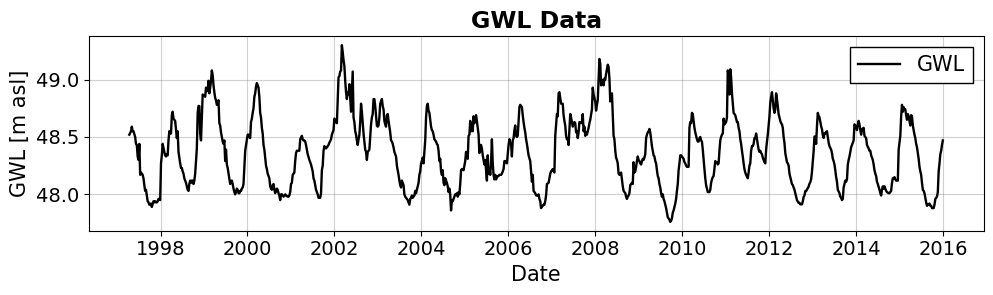

,GWL,P,rH,T,Tsin
Date,,,,,
1997-04-14,48.520,1.203046,62.731979,6.593939,-1.439494
1997-04-21,48.535,0.864522,61.926402,4.493416,-0.347873
1997-04-28,48.550,7.486455,62.071464,9.000969,0.748794
1997-05-05,48.590,30.453424,80.260318,11.661238,1.834601
1997-05-12,48.550,15.360879,71.335400,10.898702,2.893801


In [3]:

GWData = pd.read_csv('./GW-Data.csv',
                     parse_dates=['Date'], # This is used to recognise times as dates
                     index_col=0, # defines which column of the read data is to serve as the index for the DataFrame
                     dayfirst = True,  #defines the date format  
                     decimal = '.', sep=',') #Specifies which separators are used in the file

ClimateData = pd.read_csv('Climate-Data.csv', 
                          parse_dates=['Date'],index_col=0,dayfirst = True,
                          decimal = '.', sep=',')

# Merge Dataframes
data = pd.merge(GWData, ClimateData, how='inner', left_index = True, right_index = True)


#plot GWL data
plt.figure(figsize=(10,3))
plt.plot(data.index,data['GWL'], 'k', label ="GWL", linewidth = 1.7)
plt.title("GWL Data", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#inspect the data
data.head()

Der DataFrame setzt sich nun zusammen aus der Indexspalte **Date**, dem Grundwasserstand **GWL**, Niederschlag **P**, relativer Feuchte **rH**, Temperatur **T** und einem geglätteten Temperatursignal **Tsin** (Sinuskurve an T gefittet).  

Parameter **rH** und **Tsin** werden zunächst nicht benötigt (*drop*).

In [4]:
try: 
    data = data.drop(columns=['rH','Tsin'])
    print("dropped")
except: 
    print("already dropped")

dropped


we are using sequence models!
   
Wir definieren wir eine Funktion die genau das für uns erledigt und die wir immer wieder verwenden können: *make_sequences*    

Diese können wir nachher mit folgender Zeile aufrufen:  
*X,Y = make_sequences(data, n_steps_in)*

Inhaltlich passiert folgendes:

Aus einer Zeitreihe aus Inputdaten X und Zieldaten Y:  
    
    XXXXXXXXXXXXXXX  
    YYYYYYYYYYYYYYY  

werden kleine Schnipsel die jeder Inputsequenz der Länge *n_steps_in* (hier = 4) ein Zielwert zuordnet

    XXXXY
     XXXXY
      XXXXY
       XXXXY
        XXXXY
         XXXXY
          XXXXY
          ...


In [5]:
def make_sequences(data, seq_length):
#     """
#     data: numpy array with target (Y) in first column and model inputs in following columns
#     n_steps_in: number that defines the sequence length
    
#     Output:
#     X: sequenced model input data
#     Y: sequenced model target data
    
#     function modified after: machinelearningmastery.com
#     """
    
    #sequence the data
    X, Y = list(), list()
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # find the end of this pattern
        end_idx = i + seq_length
        # check if we are beyond the dataset
        if end_idx >= len(data):
            break
        # gather input and output parts of the pattern
        seq_x = data[i:end_idx, 1:]
        seq_y = data[end_idx, 0]
        X.append(seq_x)
        Y.append(seq_y)
        
    return np.array(X), np.array(Y)


### split data (diesmal in 4! Teile)

Bevor wir die Daten in Sequenzen umwandeln, müssen wir aber zunächst noch den bekannten Train-Test-Split durchführen und die Daten anschließend skalieren. Wichtig, KEIN shuffling!

Da wir eine Optimierungsfunktion nutzen und data leakage ins testset vermeiden möchten, brauchen wir diesmal 4 Teile unserer Daten.
  
**Training, Early Stopping (Validation), Optimierungs und Testing**  

Wir nutzen folgende Aufeilung:
* Test: >= 2012  
* Optimierung: 2011  
* Early Stopping: 2010  
* Training: < 2010  

In [6]:
val_startdate = pd.to_datetime('01012010', format='%d%m%Y')
opt_startdate = pd.to_datetime('01012011', format='%d%m%Y')
test_startdate = pd.to_datetime('01012012', format='%d%m%Y')

#print dates
print("Start Stopset:\n{}\n\nStart Optset:\n{}\n\nStart Testset:\n{}".format(val_startdate,opt_startdate,test_startdate))

#Here we divide the data, but do not let them overlap(!), this depends on n_steps_in, which we have not yet defined

TrainingData = data[(data.index < val_startdate)] 
StopData = data[(data.index >= val_startdate) & (data.index < opt_startdate)]
OptData = data[(data.index >= opt_startdate) & (data.index < test_startdate)]
TestData = data[(data.index >= test_startdate)] 

Start Stopset:
2010-01-01 00:00:00

Start Optset:
2011-01-01 00:00:00

Start Testset:
2012-01-01 00:00:00


### Bayesische Optimierung: Ab hier wird es etwas anders...   
Die Bayesische Optimierung kann nur auf eine Funktion angewendet werden. Wie bereits angesprochen möchten wir *seq_length* optimieren. Alles was nach der Festlegung dieses Parameters erst durchgeführt werden kann (z.B. die Überlappung der der Daten-Sets) muss also in diese Funktion reingeschrieben werden. 

Mit anderen Worten, wir geben dem Optimierungsalgorithmus eine Funktion die alles tut (Daten bearbeiten, Modell aufbauen trainieren, vorhersagen, evaluieren und eine Metrik ausgeben) was wir wollen, aber in Abhängigkeit des zu optimierenden Parameters *seq_length*.

Eine solche Funktion sieht vereinfacht so aus:

```python
def bayesopt_function(seq_length): 
    #hier [CODE] werden die Daten geteilt, skaliert, das Modell aufgebaut, trainiert und evaluiert etc.
    #[...]
    return -MSE # oder irgendeine andere Metrik zur Beurteilung des Modells
```

Die Funktion nimmt verschiedene Inputparameter, baut dann das Modell (inkl. aller dafür notwendigen Schritte) und gibt uns den negativen MSE zurück, den wir maximieren möchten (also den Fehler(MSE) minimieren).


In [7]:

def bayesoptfunction(seq_length): 
   
    #First we have to make sure that seq_length is an integer. 
    #The optimisation algorithm always outputs float numbers, we convert these into an integer:
    
    seq_length = int(seq_length)
   
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #Now follow the familiar steps as in the last appointment for time series prediction.
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #extend with overlap to be able to fill sequence (n_steps_in) later                                              
    StopData_ext = pd.concat([TrainingData.iloc[-seq_length:], StopData], axis=0) #takes last steps of TrainingData and combines it with StopData
    OptData_ext = pd.concat([StopData.iloc[-seq_length:], OptData], axis=0) #takes last steps of ValidationData and combines it with OptData
    #The test data is not required here in this function, instead we use the option set for evaluation.
    
    #create scalers and fit to data data (normalize: *_n):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(TrainingData) # fit on training data, scale all other parts afterwards

    scaler_gwl = MinMaxScaler(feature_range=(-1, 1)) 
    scaler_gwl.fit(pd.DataFrame(TrainingData['GWL'])) # fit scaler only on GWL for rescaling later
    
    #scale (transform) data
    TrainingData_n = scaler.transform(TrainingData)
    StopData_ext_n = scaler.transform(StopData_ext)
    OptData_ext_n = scaler.transform(OptData_ext)
    
    #Convert data into sequences:
    X_train,Y_train = make_sequences(np.asarray(TrainingData_n), seq_length)
    X_stop,Y_stop = make_sequences(np.asarray(StopData_ext_n), seq_length)
    X_opt,Y_opt = make_sequences(np.asarray(OptData_ext_n), seq_length)
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #build and train Model:
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #set seed
    ini=0
    seed(ini+872527)
    tf.random.set_seed(ini+87747)
    
    #build Model
    inp = Input(shape=(seq_length, X_train.shape[2])) 
    lstm = LSTM(32)(inp) 
    dense = Dense(30, activation='relu')(lstm) 
    output = Dense(1, activation='linear')(dense) 
    model = Model(inputs=inp, outputs=output)
    #define optimizer
    Adam = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)
  
    #compile the model
    model.compile(loss='mse', optimizer=Adam, metrics=['mse'])

    #define early stopping callback
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

    #train the model
    history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                        batch_size=32, callbacks=[es])

    #plot training loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training loss','validation loss'])
    plt.title('Loss')
    plt.show()
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #Test and evaluate
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #Test model with X_opt
    sim = model.predict(X_opt)

    #rescale simulated and observed values
    sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
    obs = scaler_gwl.inverse_transform(Y_opt.reshape(-1,1))
    
    #Mean Squared Error
    MSE =  np.mean((sim-obs) ** 2)
    
    #Plot Optset Simulation to see something during Optimization
    plt.figure(figsize=(6,4))
    plt.plot(OptData.index, sim, 'r', label ="simulated", linewidth = 1.7)
    plt.plot(OptData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

    plt.title("Opt Result",fontweight = 'bold')
    plt.ylabel('GWL [m asl]')
    plt.xlabel('Date')
    plt.legend(fancybox = False, framealpha = 1, edgecolor = 'k')
    plt.tight_layout()
    plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
    plt.xticks()
    plt.yticks()
    plt.show()
    
    return -MSE


Nun haben wir eine Funktion geschrieben die uns in Abhängigkeit von seq_length ein Modell aufbaut, trainiert und den -MSE dafür ausgibt.


Lasst uns nun die eigentliche Optimierung schreiben:
### Bayesische Optimierung

Nun legen wir in Form eines dictionaries fest welche HP optimiert werden sollen
und in welchen Bereichen die Werte diese HP liegen sollen (parameter bounds).
In unserem Fall enthält das Dictionary nur seq_length:
```python
pbounds = {'A': (AMin,AMax),
           'B': (BMin,BMax)           } #etc...
```

In [8]:
pbounds = {'seq_length': (1,50)} 

Wir optimieren seq_length also von einer Woche bis 50 Wochen. Dies entspricht fast bis zu ein Jahr (52 Wochen), wir bleiben jedoch knapp darunter, weil wir sonst die Überlappung der Datensätze anders coden müssten, da unser Stopset nur 1 Jahr lang ist.

Im folgenden führen wir nun fogende Schritte durch:
1. Optimizer definieren
2. Logger definieren
3. Optimieren
4. Nach Abschluss: optimalen Wert für *seq_length* auslesen

I0000 00:00:1751884836.423543 1986258 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:b5:00.0, compute capability: 8.9


Epoch 1/100


I0000 00:00:1751884838.143340 1986738 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


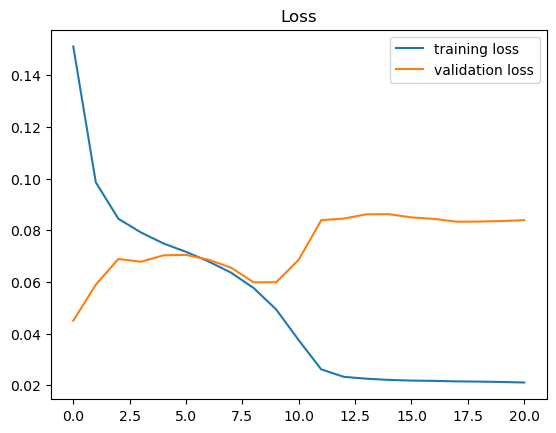

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


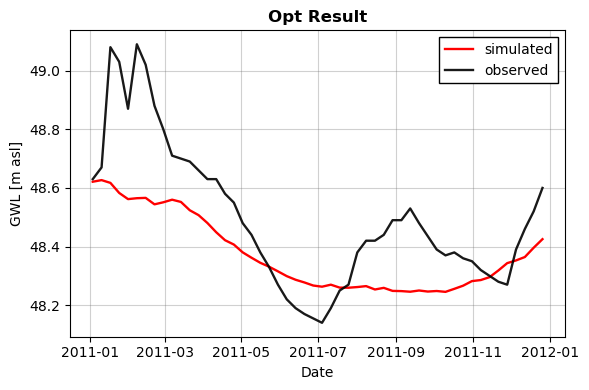

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


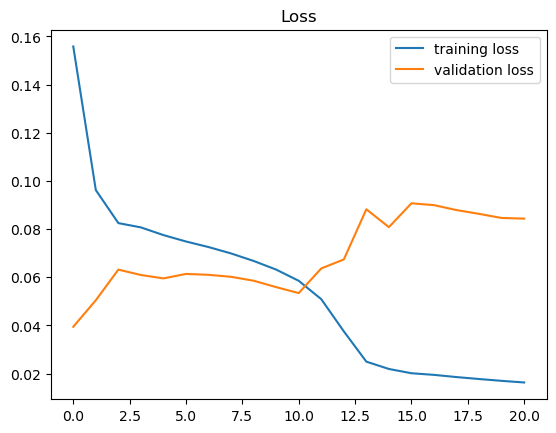

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


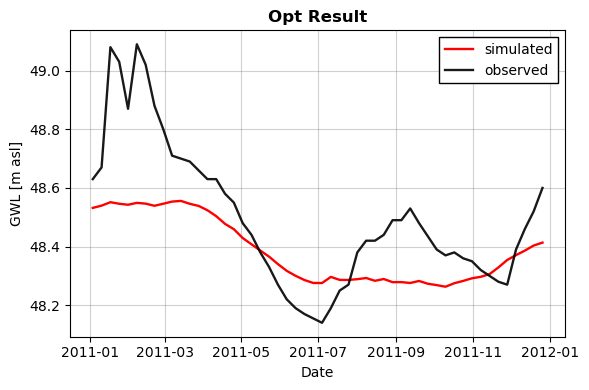

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100


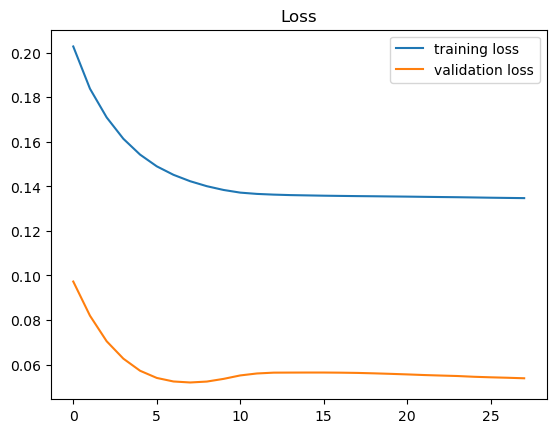

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f689c46aca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


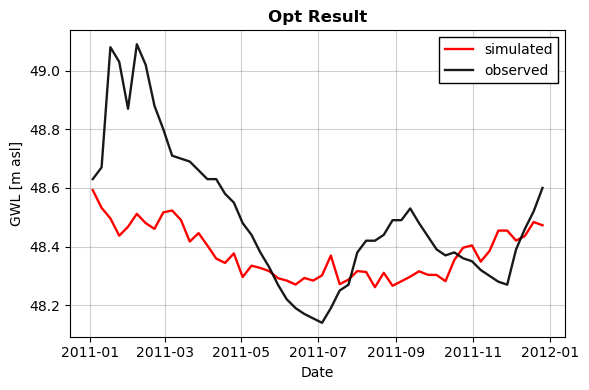

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


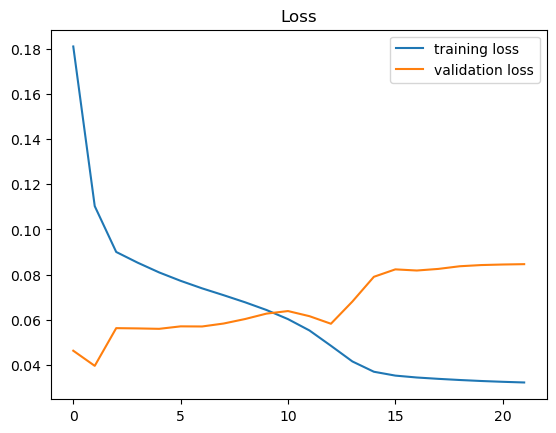

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


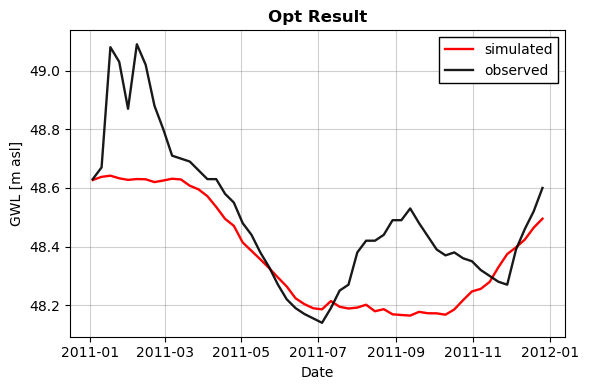

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


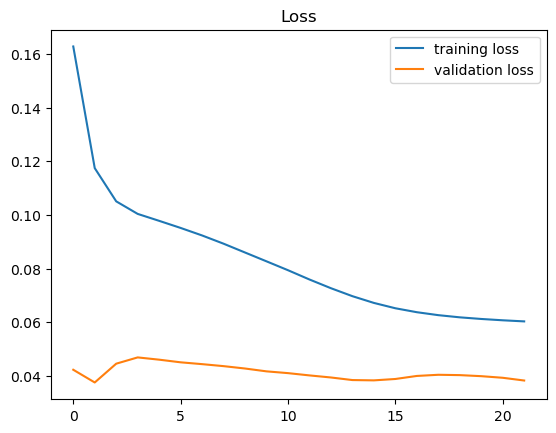

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


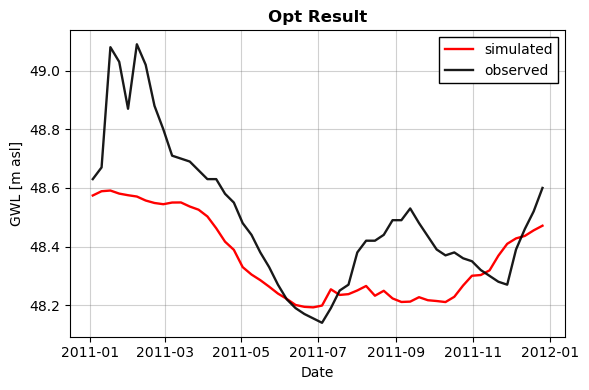

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


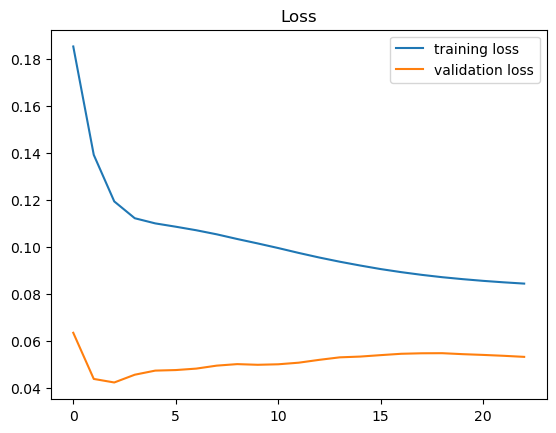

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


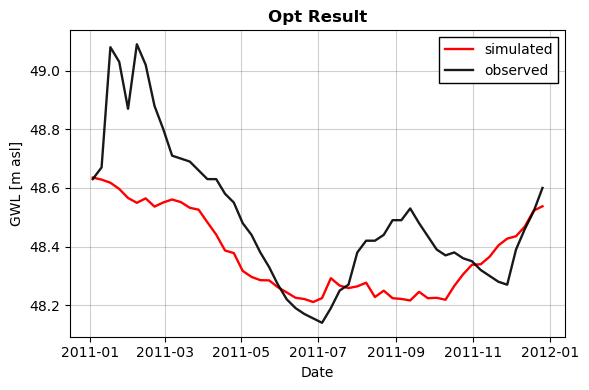

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


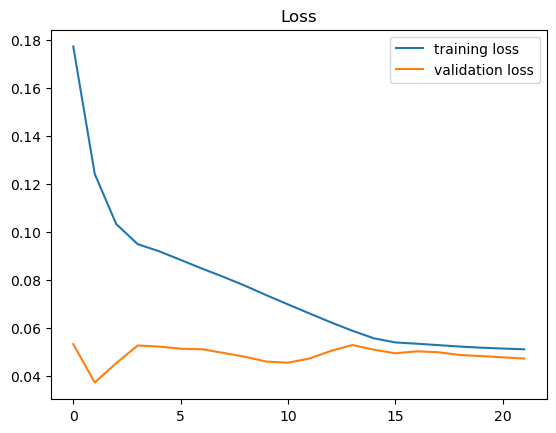

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


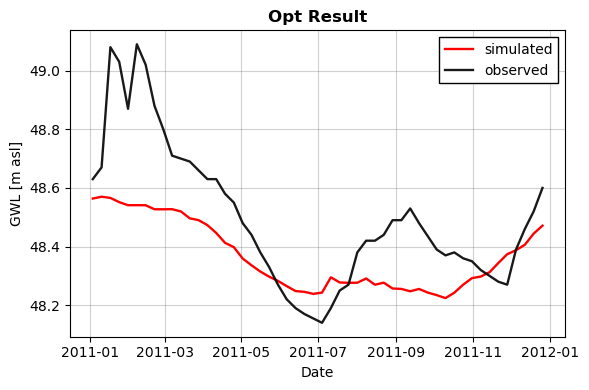

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


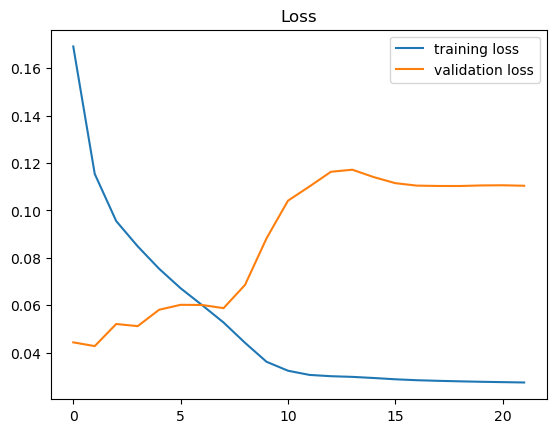

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


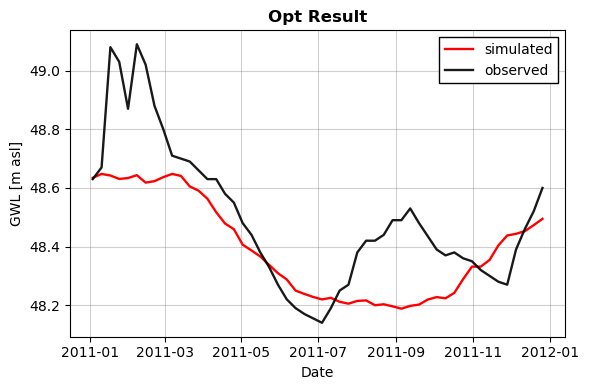

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


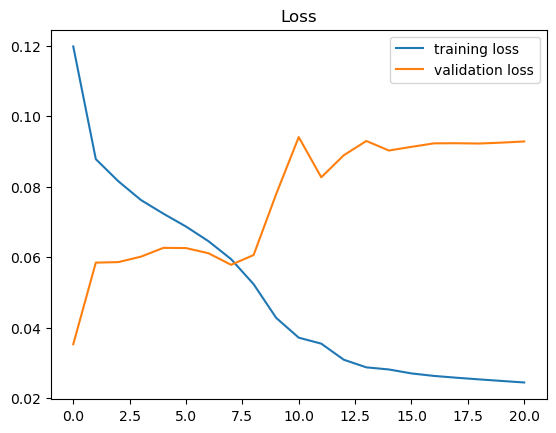

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


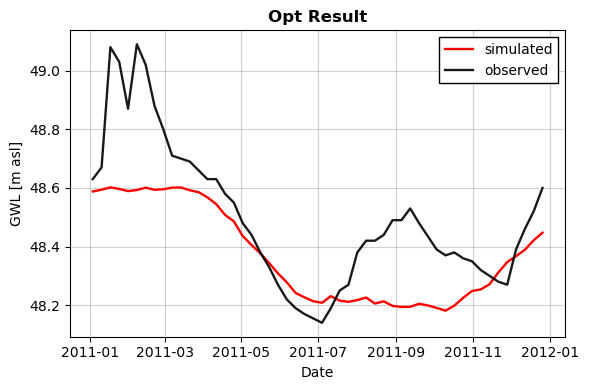

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


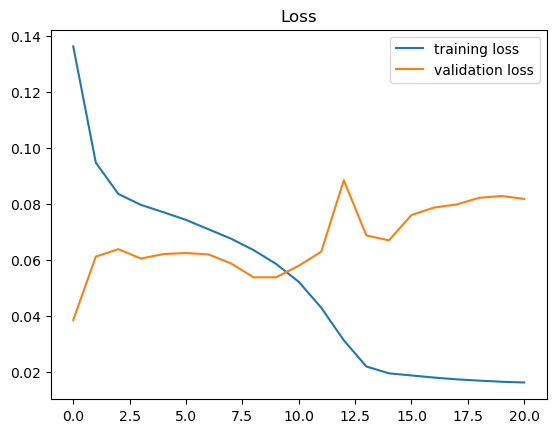

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


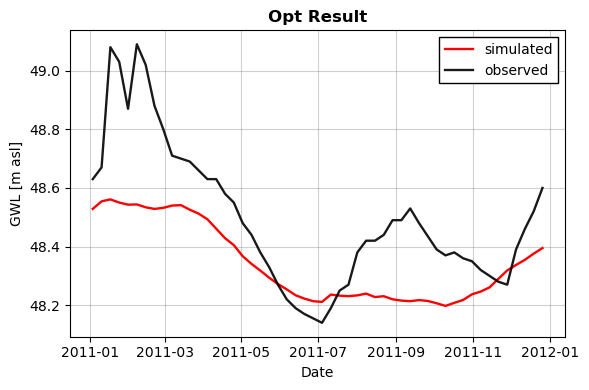

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


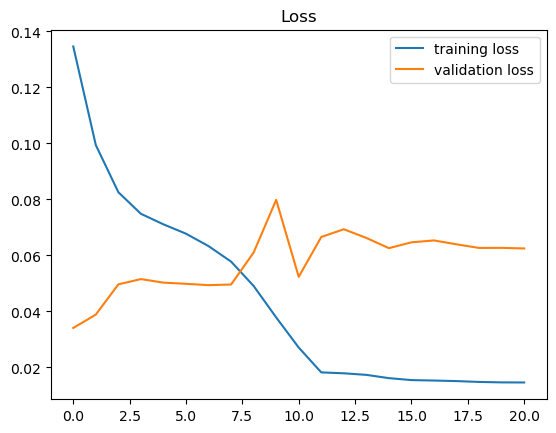

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


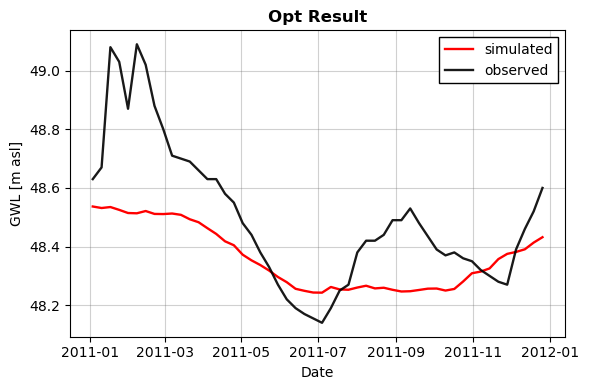

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


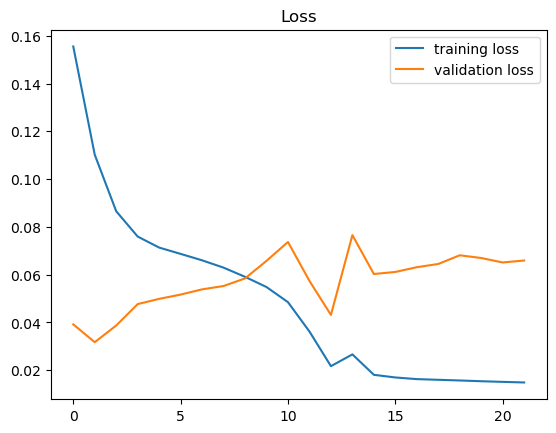

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


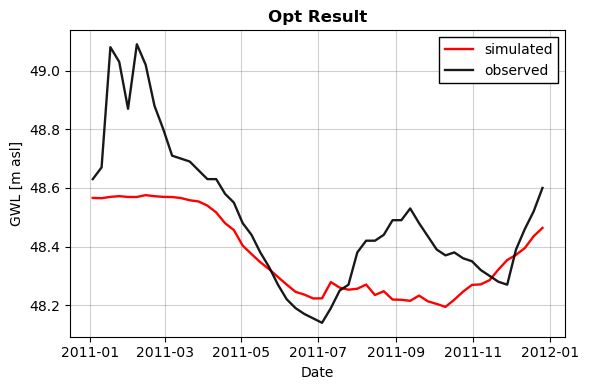

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


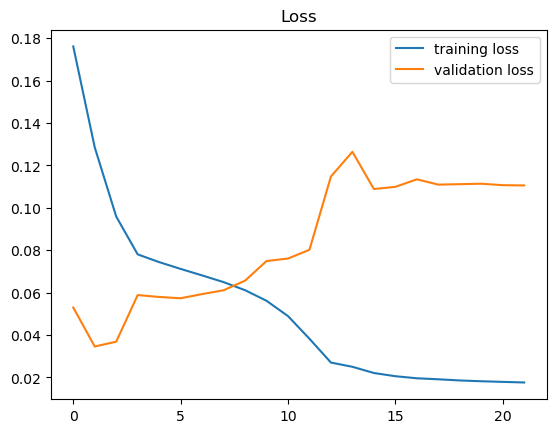

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


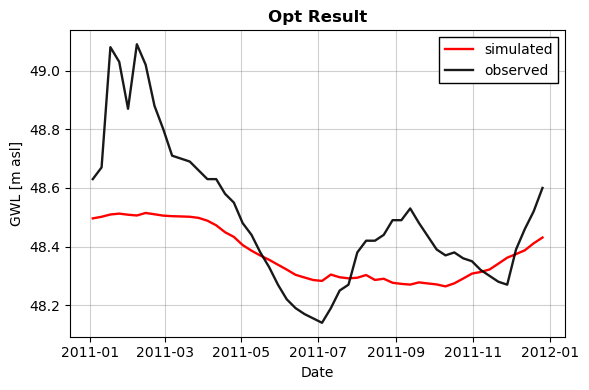

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


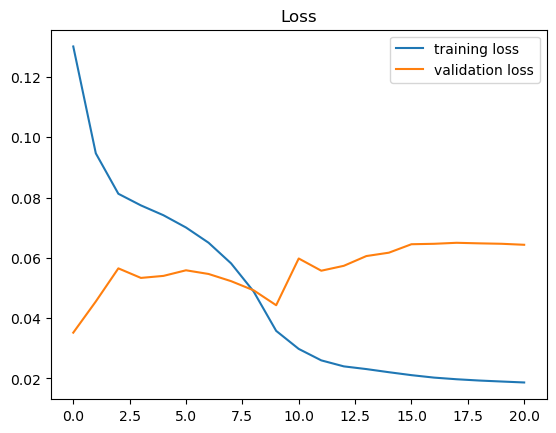

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


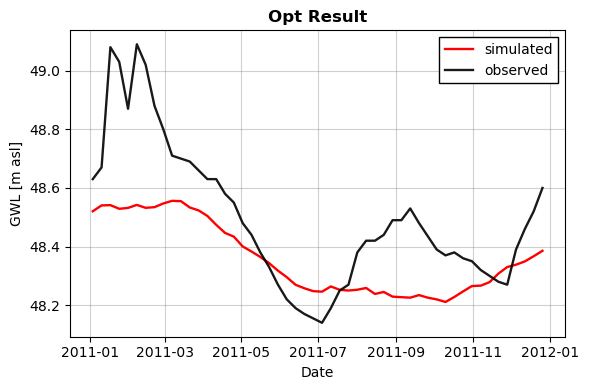

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


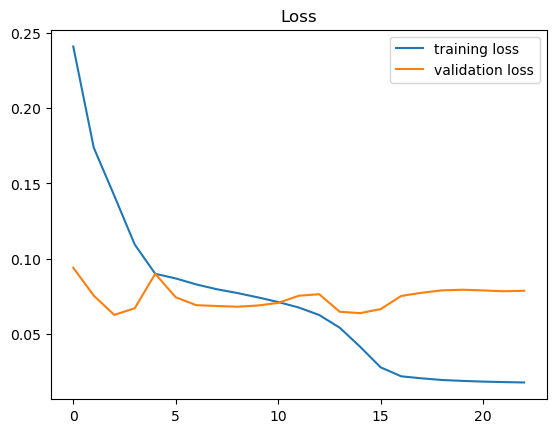

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


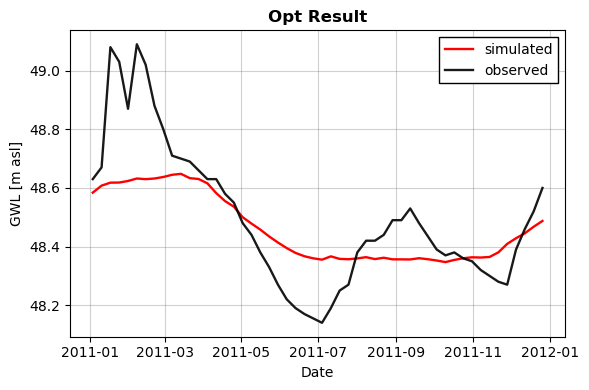

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


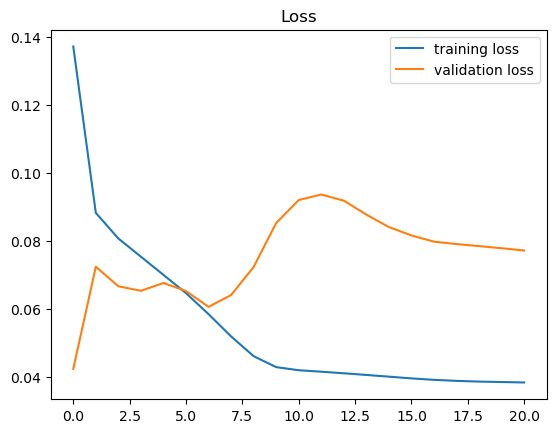

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


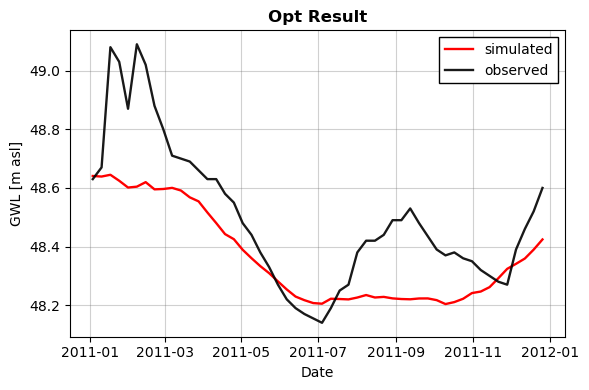

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


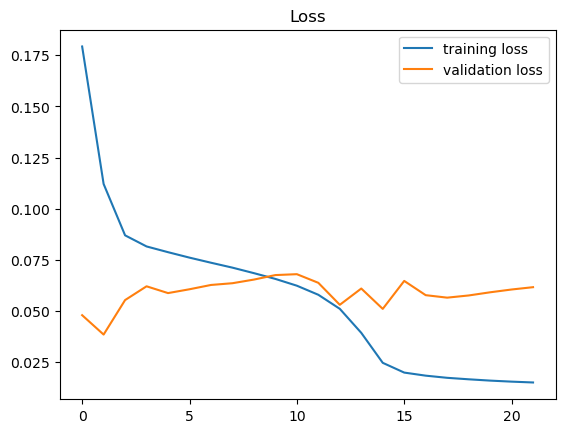

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


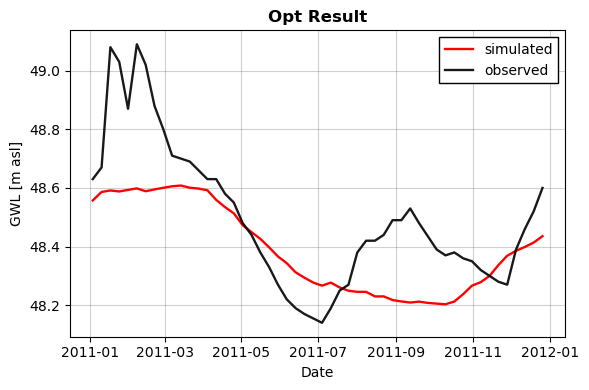

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


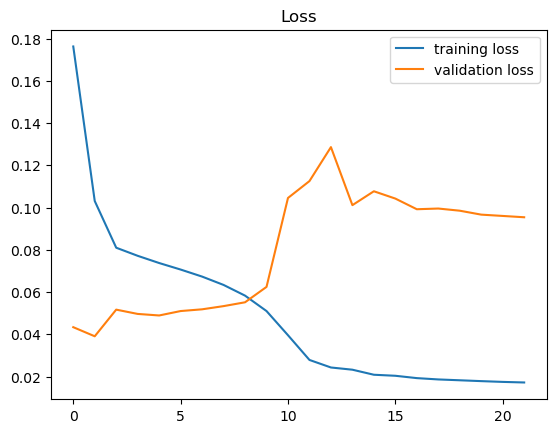

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


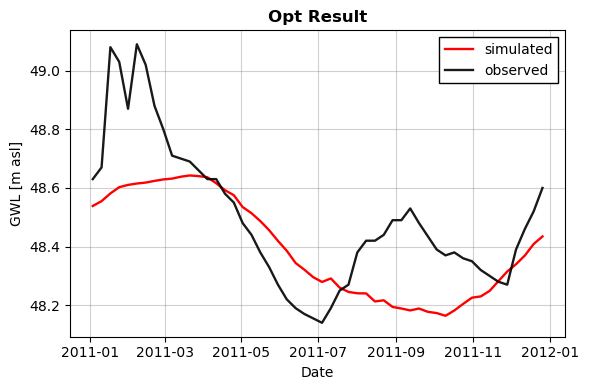

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


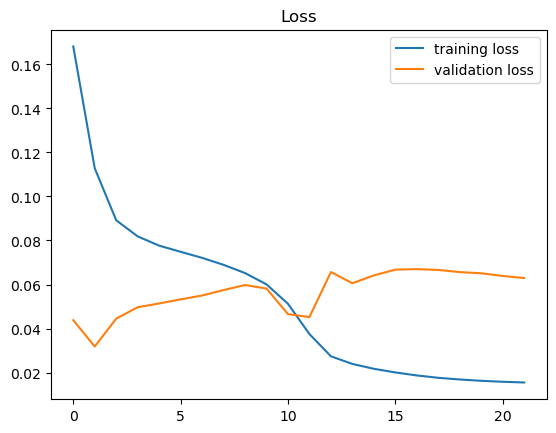

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


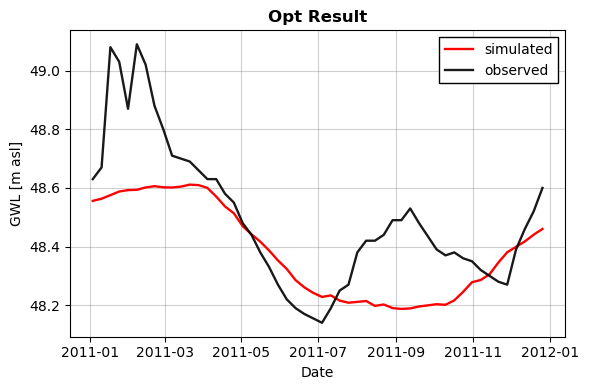

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


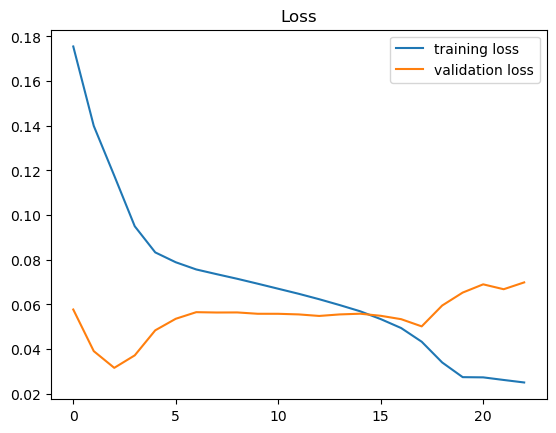

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


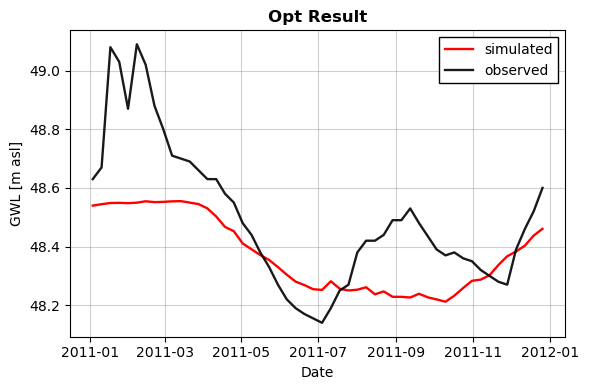

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


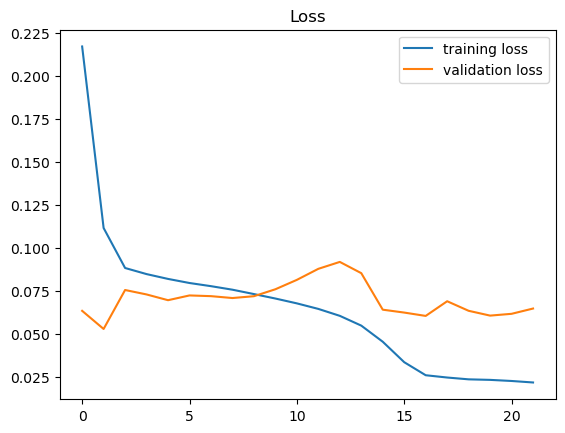

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


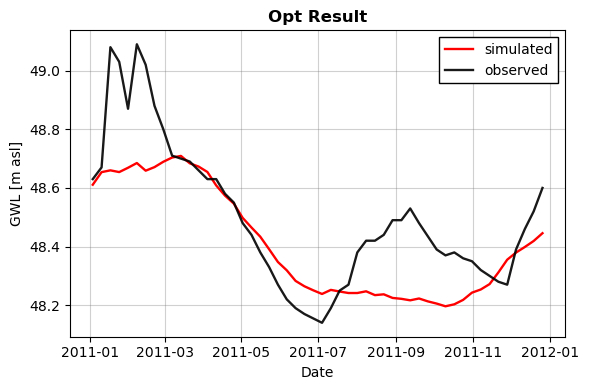

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


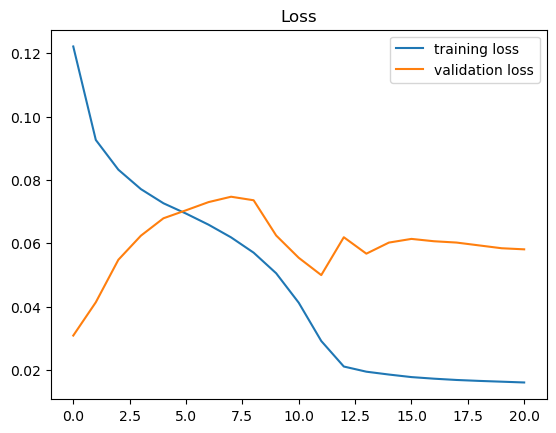

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


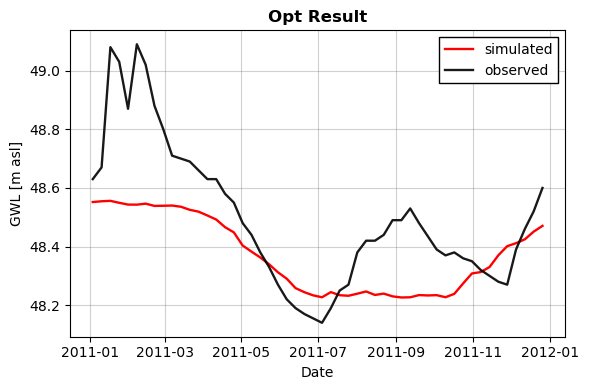

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100


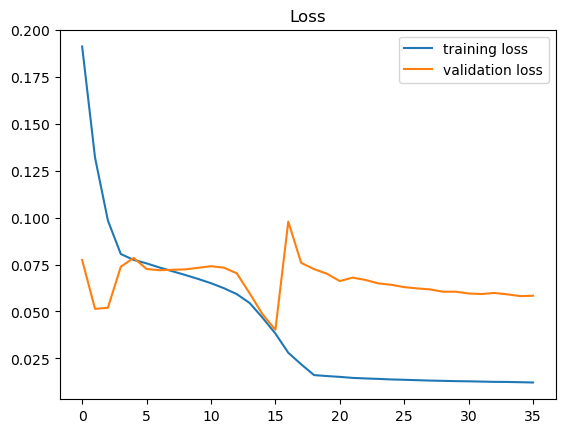

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


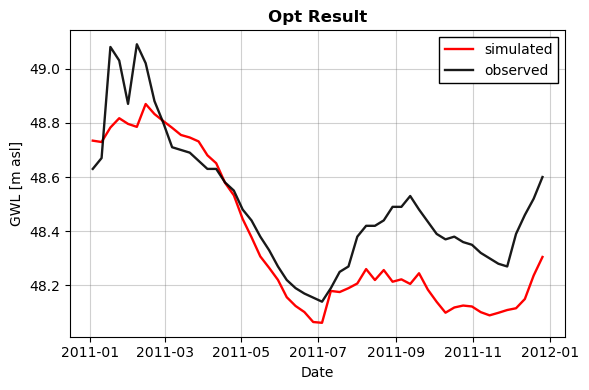

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100


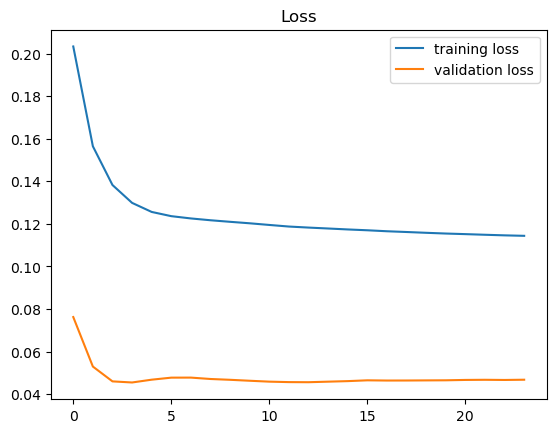

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


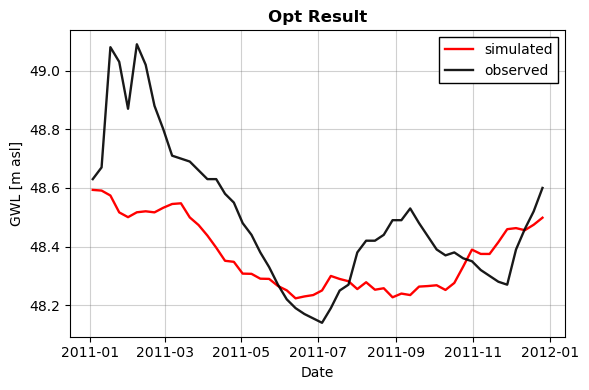

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


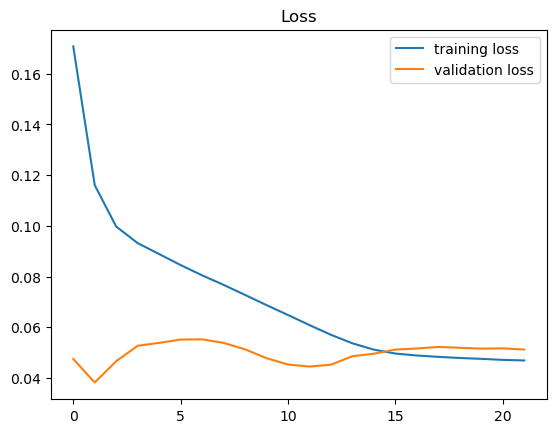

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


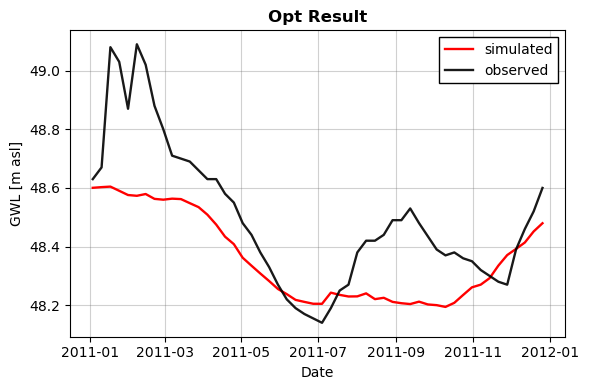

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


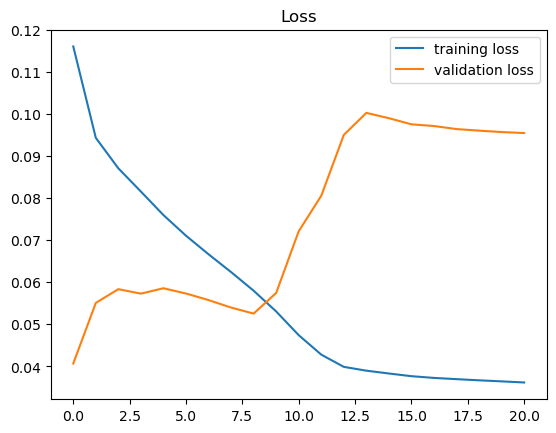

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


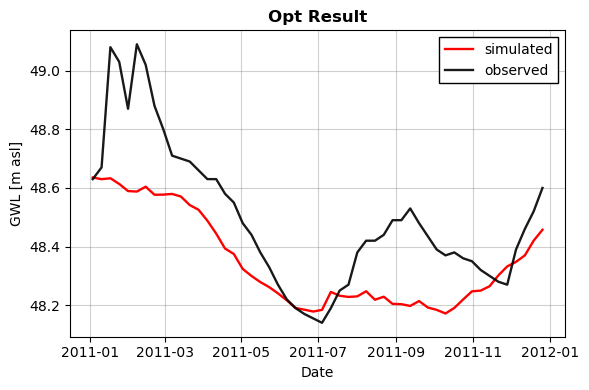

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


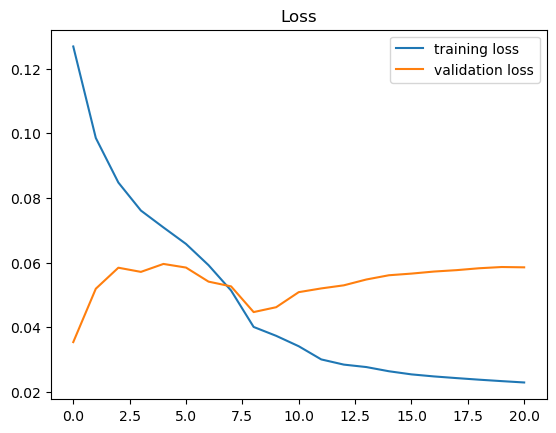

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


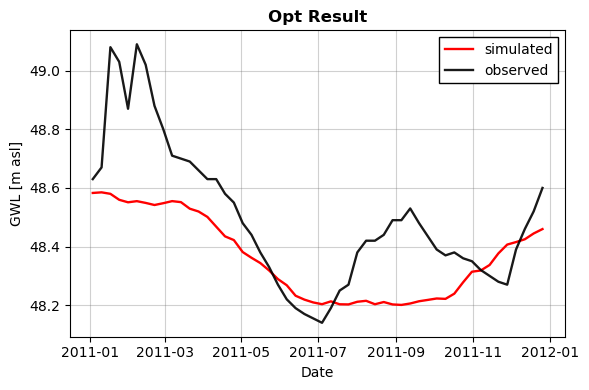

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


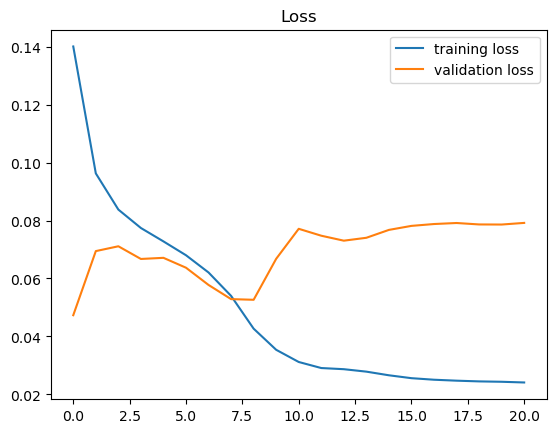

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


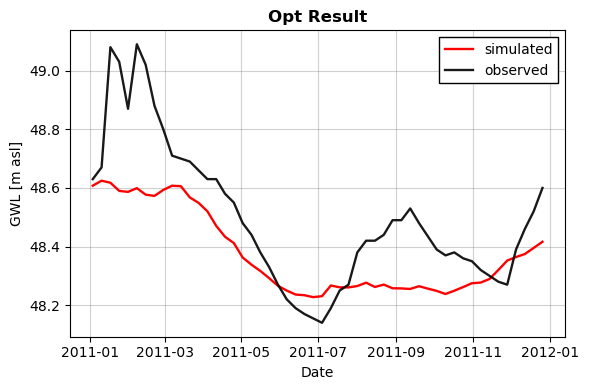

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


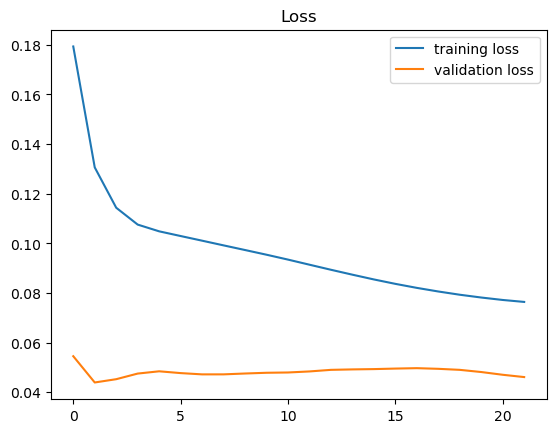

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


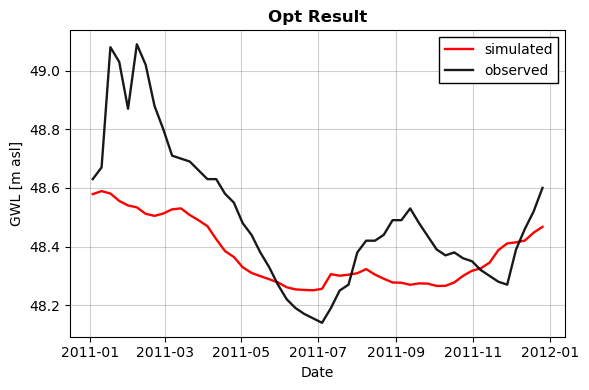

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


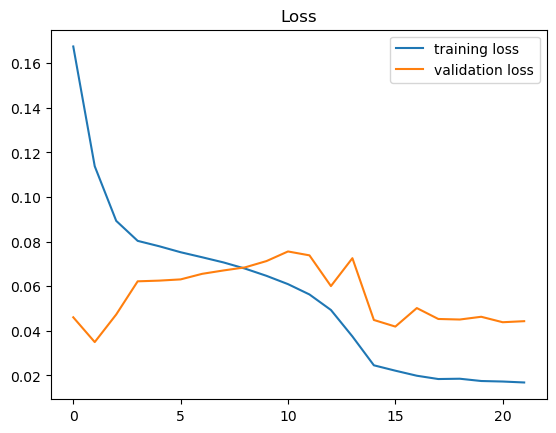

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


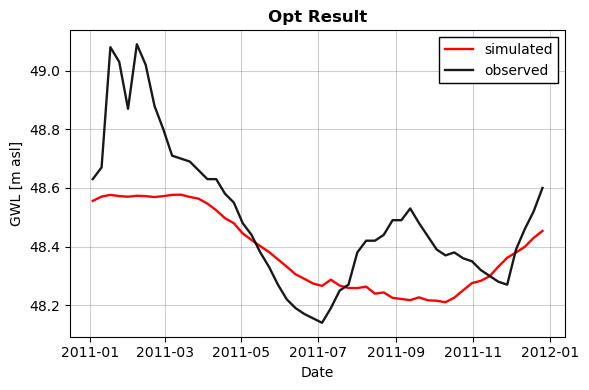

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


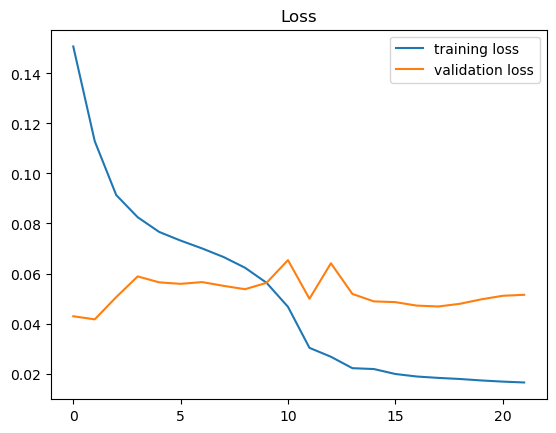

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


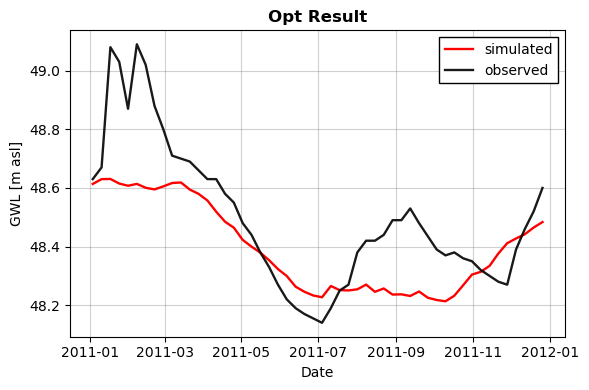

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


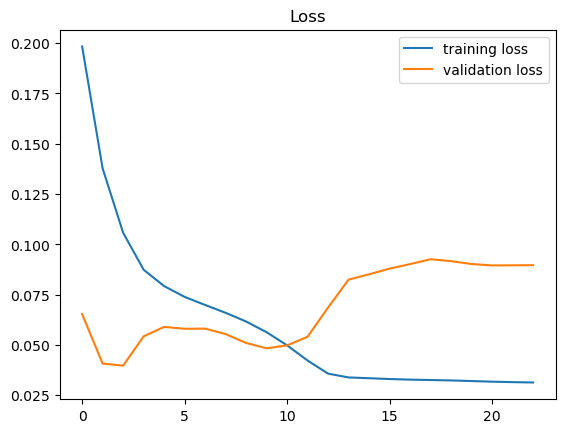

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


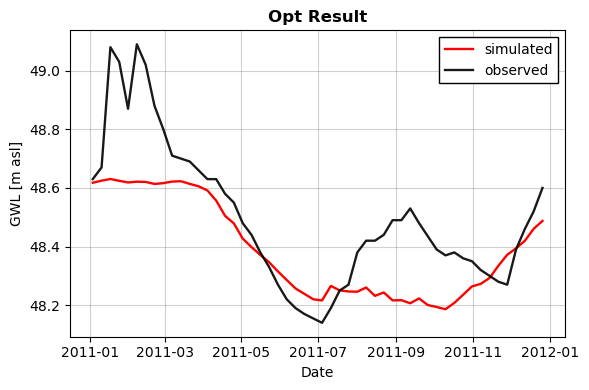

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


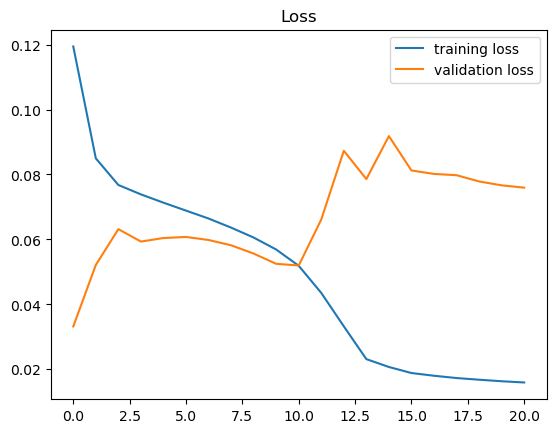

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


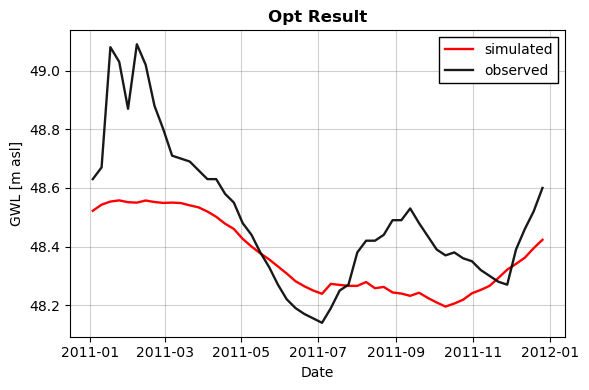

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


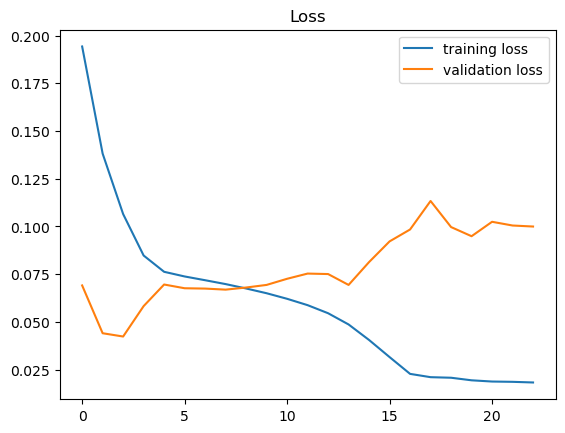

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


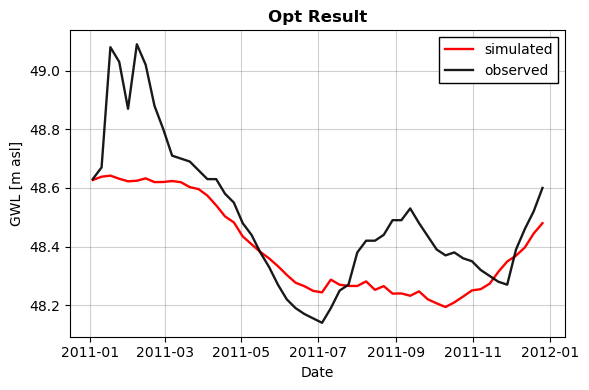

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100


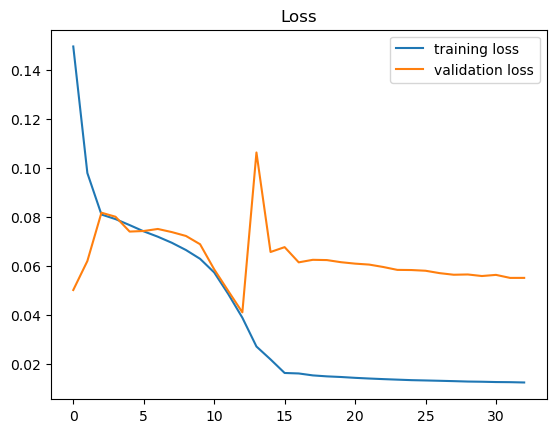

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


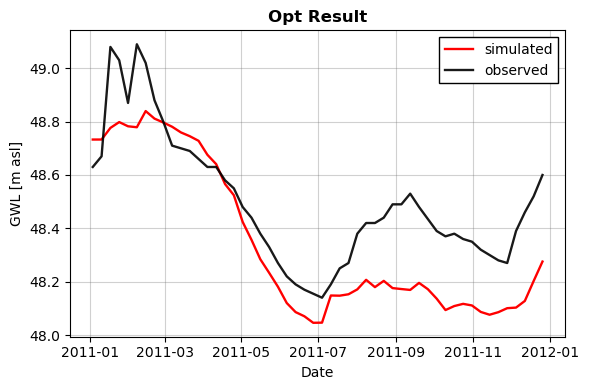

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


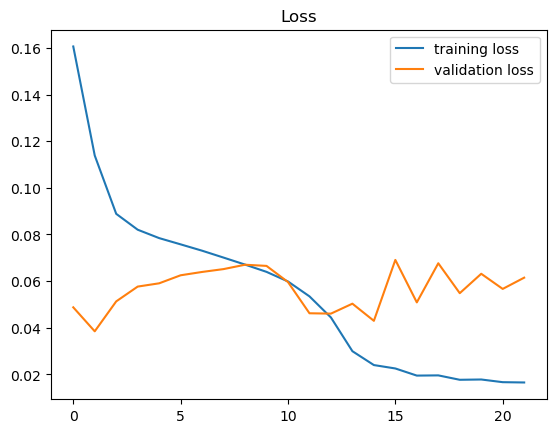

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


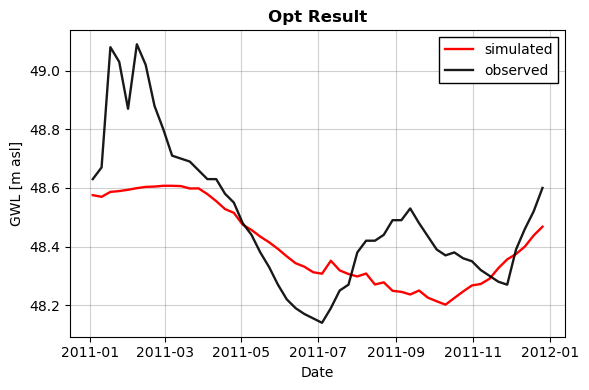

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


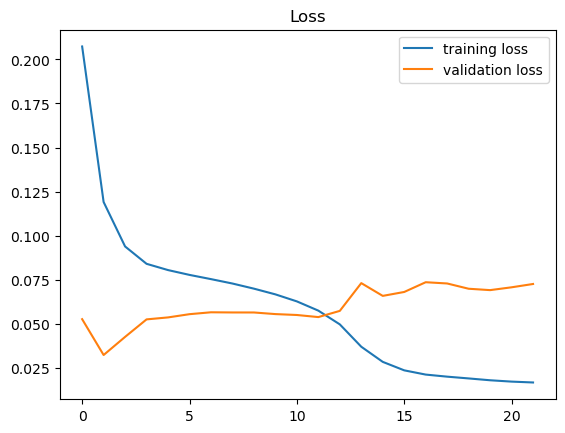

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


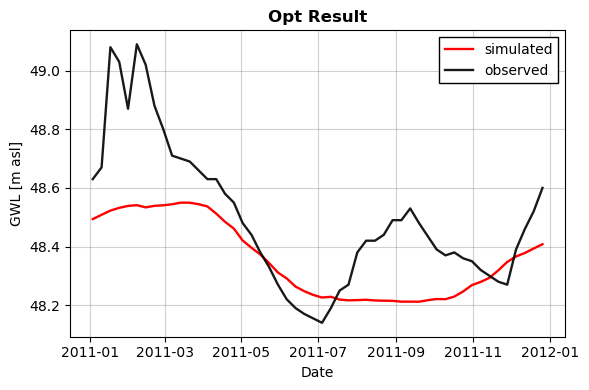

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100


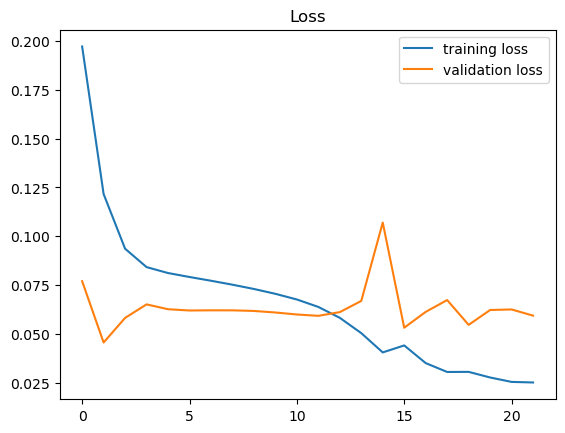

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


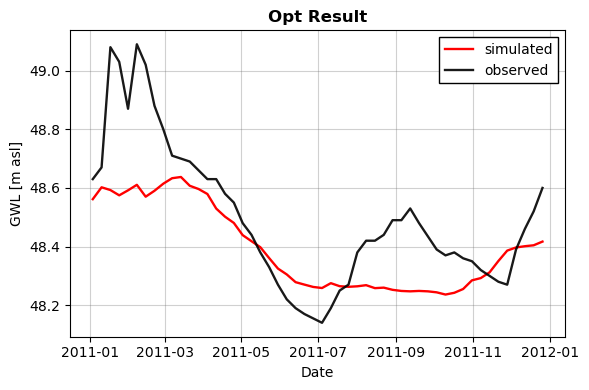

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


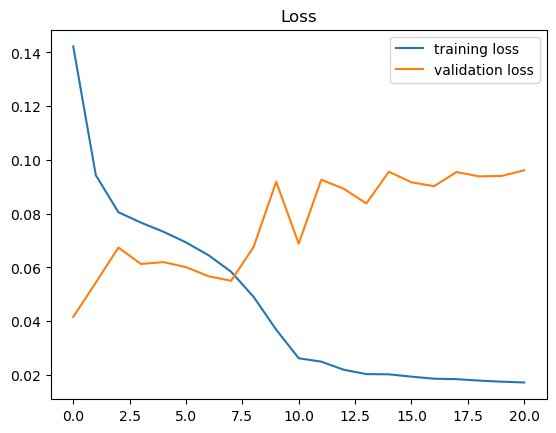

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


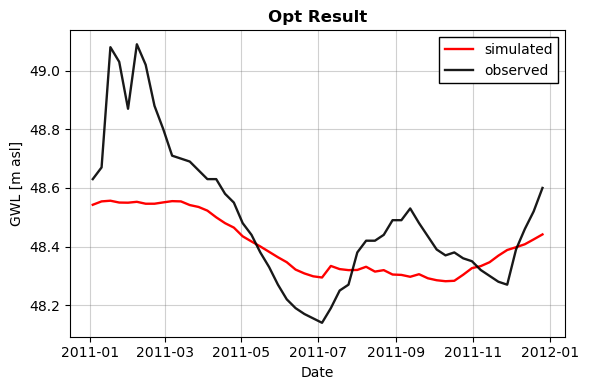

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100


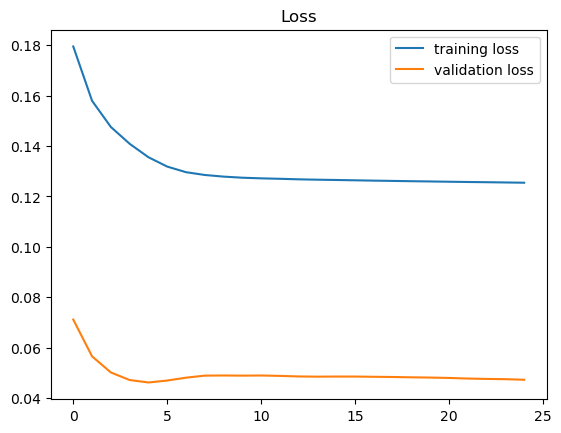

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


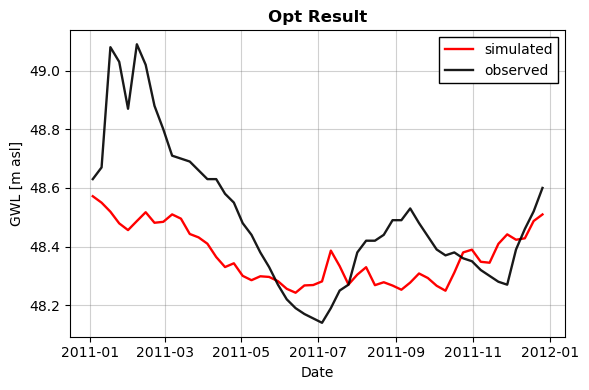

In [9]:
#Here we define the actual optimizer
optimizer = BayesianOptimization(
    f= bayesoptfunction, #name of the function to be optimized (see above the function we wrote)
    pbounds=pbounds, #value ranges in which to optimize
    random_state=1, #seed
    verbose = 0 # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent, verbose = 2 prints everything
    )

# Save progress: the logger writes the results of the iteration in a json file:
logger = JSONLogger(path="./logs.json") #Logs every optimization step in a JSON file so that the results can be analyzed or reused later.
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger) #Links the event “OPTIMIZATION_STEP” to the logger – the results are saved after each step.

optimizer.set_gp_params(normalize_y=True) #Scales the target values (output values of the function) to a normal range (e.g., 0–1), which can improve the stability and performance of the optimization.

# Create an instance of UtilityFunction for the acquisition function
acquisition_function = UtilityFunction(kind="ei", xi=0.05) 
#ei=Expected improvement, xi=balance parameter: A parameter that controls the balance between exploration (exploring new regions) and exploitation (further investigation of existing good regions). Lower values promote exploitation.

# Start the optimization
optimizer.maximize(
    init_points=10,         #First, 10 random points are evaluated (for exploration).
    n_iter=30,             #The optimizer then performs 30 optimization steps.
    acquisition_function=acquisition_function #Use the 'ei' acquisition function defined above to select the next points.
)

#After completing the optimization, we want to read out the best value for seq_length (as integer: int(...)):    
# -> get best values from optimizer

seq_length = int(optimizer.max.get("params").get("seq_length")) # Extracts the best value found for the parameter seq_length as integer

In [10]:

print("\nBEST:\t{}".format(optimizer.max)) #Outputs the best result of the optimization (best parameter combination and associated target value).

#Check after which iteration the maximum has already been reached:
beststep = False #beststep is a control flag to detect when the maximum has been found
step = -1 #step is a counter that starts at -1 because it is incremented at the very beginning.
while not beststep: 
    step = step + 1
    beststep = optimizer.res[step] == optimizer.max #optimizer.res is a list of all optimization steps (each iteration contains a result dictionary with “target” and “params”).
print("\nbest step {:.0f} of {:.0f} steps in total".format(step+1, len(optimizer.res)))

#It is checked whether the result in res[step] is equal to the global maximum (optimizer.max). If so, beststep = True → the loop ends.


BEST:	{'target': np.float64(-0.025999530161958054), 'params': {'seq_length': np.float64(24.5583643394994)}}

best step 15 of 40 steps in total


Nun wollen wir das Modell mit dem scheinbar optimalen Wert für seq_length trainieren und testen. Hierfür brauchen wir fast den gleichen Code wie in der Funktion (bayesoptfunction) oben, nur wenden wir das Modell jetzt auf Testdaten statt Optdaten an:

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


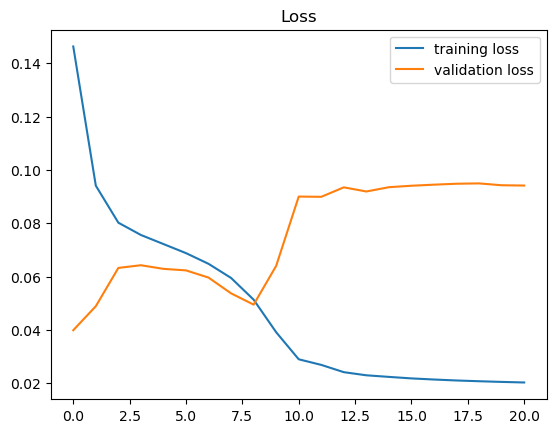

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [11]:
#We have already defined seq_length

#%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Now the familiar steps as in the last appointment for time series prediction.
#%%%%%%%%%%%%%%%%%%%%%%%%%%%

#extend with overlap to be able to fill sequence (seq_length) later                                             
StopData_ext = pd.concat([TrainingData.iloc[-seq_length:], StopData], axis=0) #takes last steps of TrainingData and combines it with StopData
# OptData_ext = pd.concat([StopData.iloc[-seq_length:], OptData], axis=0) #takes last steps of ValidationData and combines it with OptData
TestData_ext = pd.concat([OptData.iloc[-seq_length:], TestData], axis=0) #takes last steps of OptData and combines it with TestData

#create scalers and fit to data data (normalize: *_n):
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(TrainingData) # fit on training data, scale all other parts afterwards

scaler_gwl = MinMaxScaler(feature_range=(-1, 1)) 
scaler_gwl.fit(pd.DataFrame(TrainingData['GWL'])) # fit scaler only on GWL for rescaling later

#scale (transform) data
TrainingData_n = scaler.transform(TrainingData)
StopData_ext_n = scaler.transform(StopData_ext)
TestData_ext_n = scaler.transform(TestData_ext)

#Data to sequences:
X_train,Y_train = make_sequences(np.asarray(TrainingData_n), seq_length)
X_stop,Y_stop = make_sequences(np.asarray(StopData_ext_n), seq_length)
X_test,Y_test = make_sequences(np.asarray(TestData_ext_n), seq_length)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Build and train Model:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%

#set seed
seed(42)
tf.random.set_seed(42)

#build model
inp = Input(shape=(seq_length, X_train.shape[2])) 
lstm = LSTM(32)(inp) 
dense = Dense(30, activation='relu')(lstm) 
output = Dense(1, activation='linear')(dense) 
model = Model(inputs=inp, outputs=output)


#define optimizer
Adam = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)

#compile the model
model.compile(loss='mse', optimizer=Adam, metrics=['mse'])

#define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Testing
#%%%%%%%%%%%%%%%%%%%%%%%%%%%

#test Model with X_test
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

Nun berechnen wir wieder Fehlerwerte und Plotten das Ergebnis (analog zu oben):

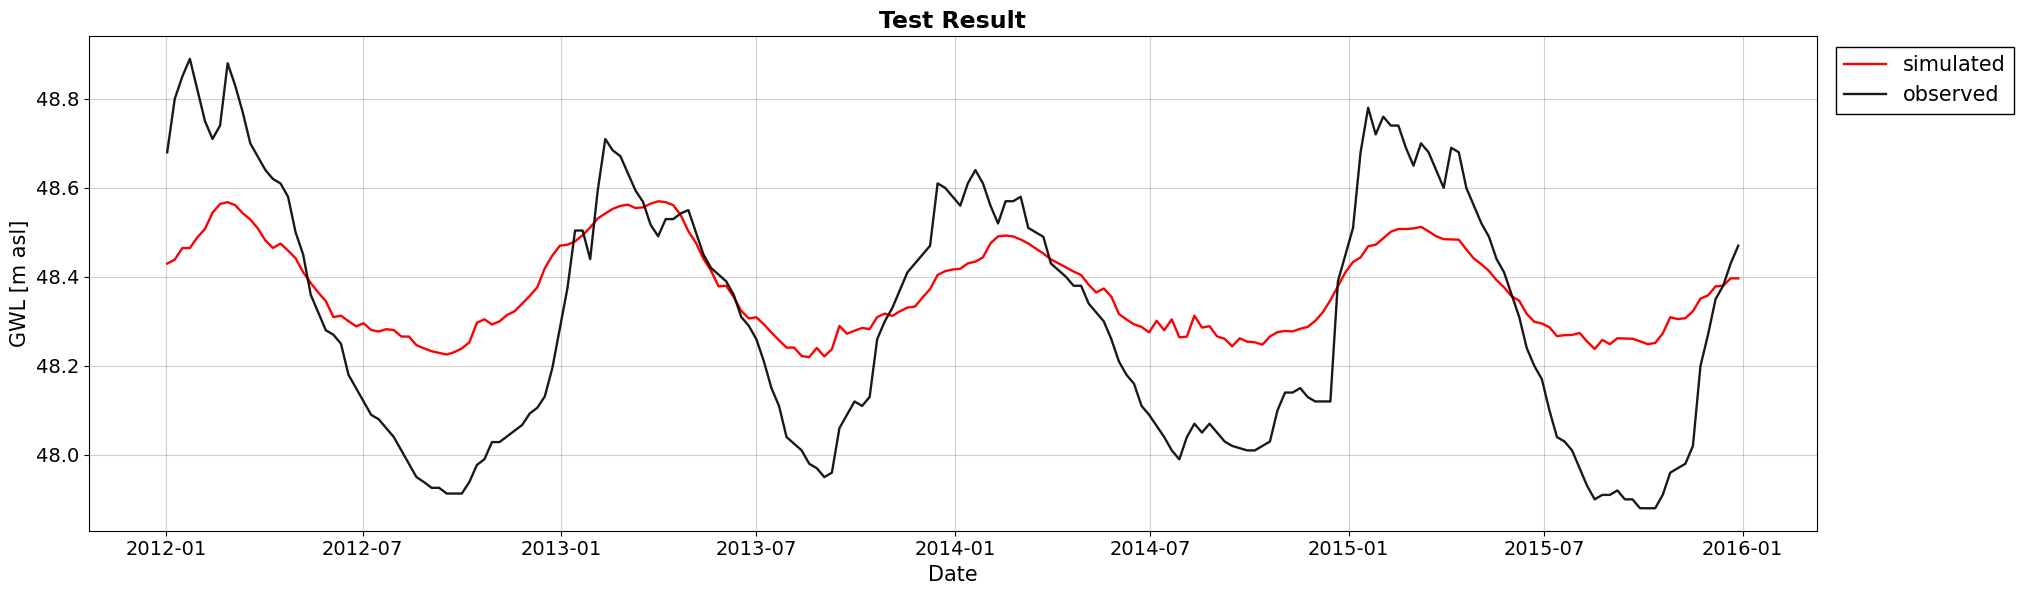

seq_length = 24 weeks


,NSE,RMSE,r,Bias
0,0.47487,0.200171,0.909458,0.066182


In [12]:

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])

#Plot testset Simulation
plt.figure(figsize=(20,6))
plt.plot(TestData.index, sim, 'r', label ="simulated", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Test Result", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.12, 1),loc='upper right',fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print("seq_length = {:.0f} weeks".format(seq_length))
scores.head()

### Aufgabe 1: zusätzlichen Hyperparameter optimieren

Wir möchten neben seq_length nun auch die Anzahl der LSTm units im LSTM Layer optimieren. Der Parameter soll *n* heißen.

Ändere den obigen Code so, dass beide Parameter optimiert werden. nutze dafür folende Anleitung:  
* Füge *n* der Funktion *bayesoptfunction* als Input parameter hinzu (gnau wie seq_length):
```python
    def bayesoptfunction(seq_length,n): 
```
* Wandle *n* zu Beginn der Funktion in einen integer um (genau wie seq_length)
* Füge *n* an entsprechener Stelle im LSTM Layer ein
```python
    ...(units=n)... 
```
* Optimiere *n* für einen Wertebereich von 10 bis 50 (Parameter dem pbounds Dict hinzufügen)
```python
pbounds = {'A': (AMin,AMax),
           'B': (BMin,BMax)           } #etc...
```
* Entnehme den besten Wert für n dem optimizer mit folgendem Befehl: 
```python
n = int(optimizer.max.get("params").get("n"))* 
```
* Übernehme den gefundenen Wert für *n* auch im Code für das Model, welches für die Testdaten verwendet wird

Tipp: Entweder du änderst direkt den Code den du oberhalb findest (dann am besten das Notebook als Kopie abspeichern), oder kopiere dir den Code nach unten und erstellst neue Zellen. 

### Aufgabe 2: Einfaches Modell Ensemble

Alle ANN werden mit (quasi)zufälligen Werten der Gewichte initialisiert. Um das Modell reproduzierbar zu halten, setzen wir immer den random seed vor jedem Durchlauf. Dies können wir aber auch nutzen um ein Ensemble zu erstellen, welches uns zeigt wie stark das Ergebnis vom random seed abhängt. ANstatt nun also immer den gleichen seed zu wählen, definieren wir mehrere Modelle mit unterschiedlichen Initialisierungen. 

Schreibe daher die übernächste Notebookzelle (Nur eine Kopie des Codes von oben) als **Schleife** bei der der Parameter *ini* von 0 bis 4 (also 5 verschiedene Werte: 0,1,2,3,4) varriert wird. Vergiss dafür nicht alle Zeilen nach dem Einrichten der Schleife einzurücken. 

Wir definieren zuvor die Variable *sim_all* in die die Ergebnisse aller Durchläufe jeweils als Spalte eingefügt werden sollen. 

In [13]:
sim_all = np.zeros((Y_test.shape[0],5)) #This is called preallocation, 
#further down in the code, after the loop has been inserted, at each pass the result should be stored as follows: 
#sim_all[:,ini] = sim

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100


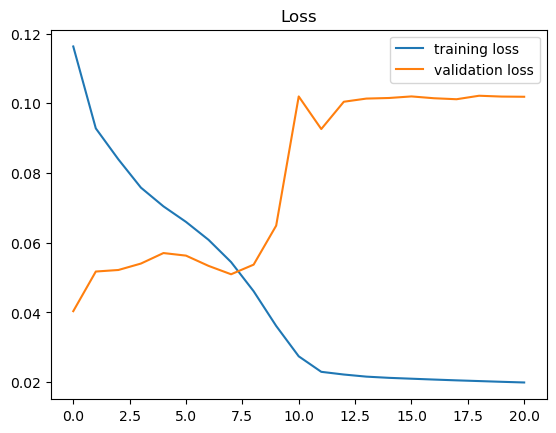

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [14]:

ini=0# The loop should start here (instead of ini=0)
seed(ini+42)
tf.random.set_seed(ini+42)

#build model
inp = Input(shape=(seq_length, X_train.shape[2])) 
lstm = LSTM(32)(inp) 
dense = Dense(30, activation='relu')(lstm) 
output = Dense(1, activation='linear')(dense) 
model = Model(inputs=inp, outputs=output)

#define optimizer
Adam = tf.keras.optimizers.Adam(learning_rate=1E-3, epsilon=1E-3, clipnorm=True)

#compile the model
model.compile(loss='mse', optimizer=Adam, metrics=['mse'])

#define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights = True)

#train the model
history = model.fit(X_train, Y_train,validation_data=(X_stop, Y_stop), epochs=100, verbose=3,
                    batch_size=32, callbacks=[es])

#plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title('Loss')
plt.show()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Testing 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%

#Modell testen mit X_test
sim = model.predict(X_test)

#rescale simulated and observed values
sim = scaler_gwl.inverse_transform(sim)  # retransform to original scale
obs = scaler_gwl.inverse_transform(Y_test.reshape(-1,1))

#fill sim_all here column by column according to the note above


Wenn ihr erfolgreich seid, könnt ihr die nächsten Zellen einfach laufen lassen ohne etwas zu ändern. Am Ende sollte einen Plot herausbekommen, der euch alle Modelle sowie den Ensemblemittelwert zeigt. 

/tmp/ipykernel_1986258/2685152868.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = stats.pearsonr(sim_mean[:,0], obs[:,0])


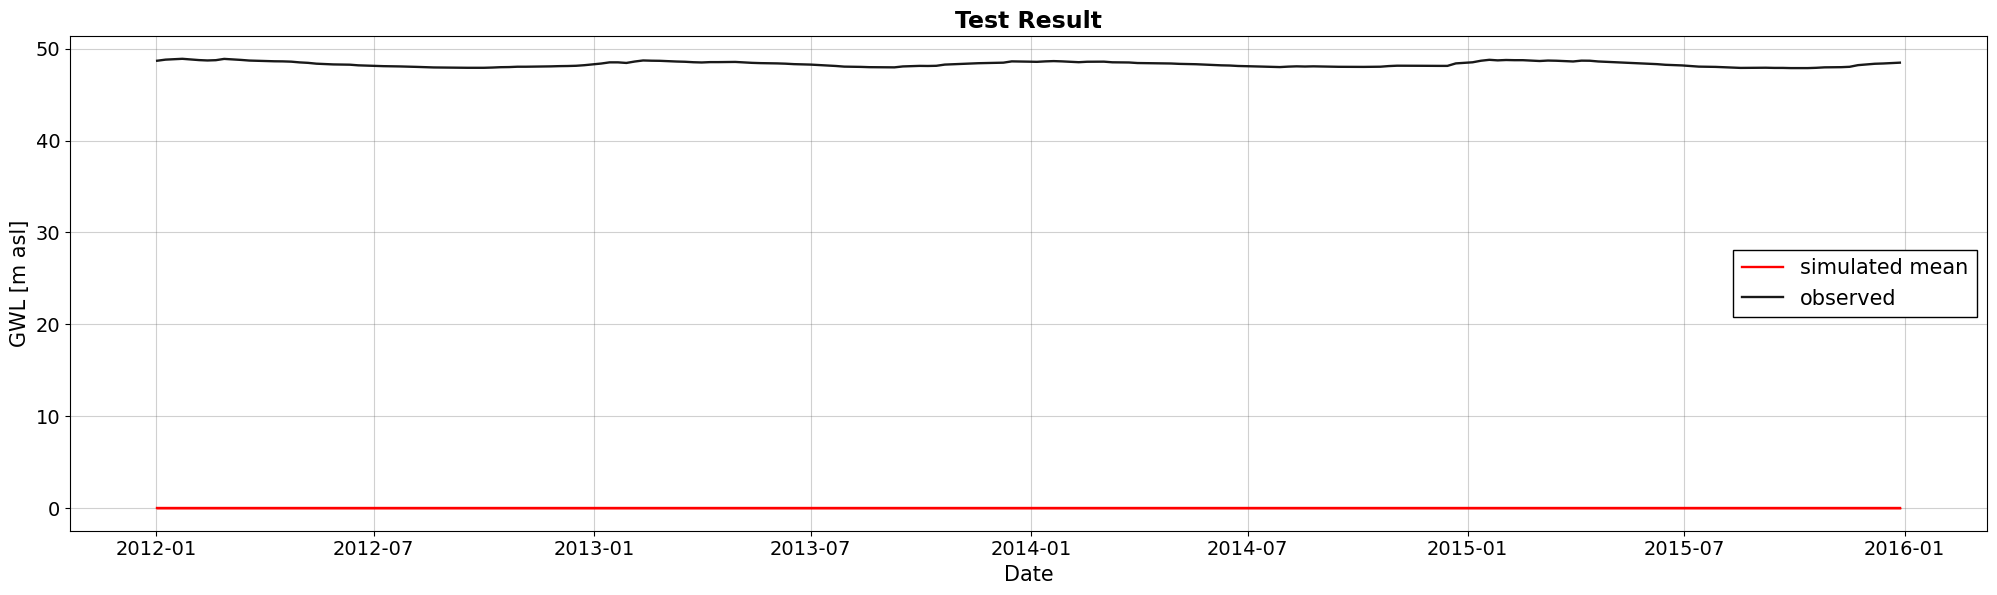

,NSE,RMSE,r,Bias
0,-30578.452188,48.304051,NaN,-48.303261


In [15]:
sim_mean = np.mean(sim_all,axis = 1).reshape(-1,1) #wir berechnen die Fheler für den Mittelwert des Ensembles

#Nash-Sutcliffe-Efficiency: NSE
NSE = 1 - ((np.sum((sim_mean-obs) ** 2)) / (np.sum((obs - np.mean(obs)) ** 2)))

#Root Mean Squared Error
RMSE =  np.sqrt(np.mean((sim_mean-obs) ** 2))

#Pearson r
r = stats.pearsonr(sim_mean[:,0], obs[:,0])
r = r[0] #r

#Bias
Bias = np.mean(sim_mean-obs)

scores = pd.DataFrame(np.array([[NSE, RMSE, r, Bias]]),
                      columns=['NSE','RMSE','r','Bias'])

#Plot testset Simulation
plt.figure(figsize=(20,6))

for i in range(5):
    plt.plot(TestData.index, sim_all[:,i], 'r', label = None, linewidth = 1, alpha = 0.5)

plt.plot(TestData.index, sim_mean, 'r', label ="simulated mean", linewidth = 1.7)
plt.plot(TestData.index, obs, 'k', label ="observed", linewidth=1.7,alpha=0.9)

plt.title("Test Result", size=17,fontweight = 'bold')
plt.ylabel('GWL [m asl]', size=15)
plt.xlabel('Date',size=15)
plt.legend(fontsize=15,fancybox = False, framealpha = 1, edgecolor = 'k')
plt.tight_layout()
plt.grid(visible=True, which='major', color='#666666', alpha = 0.3, linestyle='-')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

scores.head()